# Particle Swarm Optimisation for Graph Neural Network Architecture Search

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

# import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import Actor

from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
print(torch.cuda.device_count())

0


This GNN can handle different types of convolutional layers, and both node and graph classification.
The build_conv_model method determines which type of convolutional layer to use for the given task, a graph convolutional network for node classificationtion (GCNConv) and a graph isomorphism network for graph classification (GINConv).
This model is made of 3 covolution layers followed by mean pooling in the case of graph classification, followed by 2 fully connected layers.
Sing our goal here is classification, we use a negative log-likelihood loss function.

List of the changeable hyperparameters:

    - hidden_dim (dimmension of hidden layers)

    - number of convs layers

    - number of lns layers (normalisation layers)
    

In [3]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, output_dim, task='node', hidden_num = 2, hidden_dim = 32):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList() #convolution operations
        self.lns = nn.ModuleList() #normalisation operations
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        # adding convolution an normalisation layers
        for l in range(hidden_num):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))
            # self.lns.append(nn.LayerNorm(hidden_dim))

        # self.lns.append(nn.LayerNorm(hidden_dim))


        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim)) # adding 2 linear layers 
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = hidden_num

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        # create different types of GCNConv according to the problem to solve
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        # x = feature matrix = number of nodes * number of node feature dimensions,
        # edge_index = list of the edges in the graph,
        # batch = batch of a graph
        x, edge_index, batch = data.x, data.edge_index, data.batch

        if data.num_node_features == 0: #if there is no feature, use a constant feature
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers): # ,create num_layers convolution layers
            # print("test")
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
            # if not i == self.num_layers - 1:
            #     x = self.lns[i](x)

        if self.task == 'graph': # if it is a graph classification task, do a pooling
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

pyg_nn.GCNConv and pyg_nn.GINConv are instances of MessagePassing, They define a single layer of graph convolution, which can be decomposed into:
- Message computation
- Aggregation
- Update
- Pooling

Training the model with forward propagation and back propagation. 
For node classification, we split nodes into training and testing sets.
Same thing for graph classification, we use 80% of the graphs for training and the remainder for testing.

In [4]:
def train(dataset, task, hidden_num , hidden_dim, lr=0.01):
    trigger = 0
    prev_acc = 0.0

    if task == 'graph':
        data_size = len(dataset)
        # split data  into traning and testing set
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = DataLoader(dataset, batch_size=64, shuffle=True)
        loader = test_loader

    # build model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = GNNStack(max(dataset.num_node_features, 1), dataset.num_classes, task=task, hidden_num=hidden_num, hidden_dim=hidden_dim)
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr)
    
    # train for 200 epochs
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            # get the prediction and the excpeted label
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
            
        total_loss /= len(loader.dataset)

        
        test_acc = test(test_loader, model)
        # print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
        #     epoch, total_loss, test_acc))
        # writer.add_scalar("test accuracy", test_acc, epoch)

        if test_acc <= prev_acc:
            trigger += 1

        if trigger >= 10:
            # print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
            # epoch, total_loss, test_acc) + " | hidden_num = " + str(hidden_num) + ", hidden_dim = " + str(hidden_dim) + ", lr = " + str(lr))
            break
        prev_acc = test_acc
        
    return model, total_loss, test_acc

For the CiteSeer/Cora node classification task, there is only one graph, so we use masking to determine validation and test set. In graph classification, a subset of graphs is considered as a validation/test graph

In [5]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad(): # avoid gradient computing for faster results
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
     
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct / total

///////////////////
///////////////////
///////////////////
///////////////////

In [6]:
import copy
import random

class Particle:
    def __init__(self):
        self.hidden_dim = random.randint(2, 50)
        self.hidden_num = random.randint(2, 10)
        self.lr = round(random.uniform(0.0100, 0.0001), 4)
        # self.parameters = NN_parameters()
        self.cognitiveCoef = 1 # can be changed
        self.socialCoef = 1 # can be changed
        self.informantList = list()
        self.informants_best_err = -1
        self.best_err = -1
        self.best_wb = []
        self.informants_best = [self.hidden_num, self.hidden_dim, self.lr]
        self.err = -1  # Current error (set to -1 at start
        self.velocity_hidden_num = random.random()
        self.velocity_hidden_dim = random.random()
        self.velocity_lr = round(random.uniform(0.0100, 0.0001), 4)

    def setInformants(self, swarm, informantNum, index):
        banned_index = []
        i = 0
        swarm_buffer = copy.deepcopy(swarm)
        banned_index.append(index)
        while i < informantNum:
            informant_chosen = np.random.randint(0, len(swarm_buffer))
            if informant_chosen in banned_index:
                continue
            self.informantList.append(swarm[informant_chosen])
            banned_index.append(informant_chosen)
            i += 1

    def set_informant_best(self):
        for informer in self.informantList:
            if informer.best_err < self.informants_best_err or self.informants_best_err == -1:
                self.informants_best_err = informer.best_err
                self.informants_best = informer.best_wb
    
    def check_error(self, loss):
        self.err = 0
        if self.err < self.best_err or self.best_err == -1:
            self.best_err = self.err
            self.best_wb = [self.hidden_num, self.hidden_dim, self.lr]

    def update_velocity(self):
        inertia_weight = 1

        # Change the velocity values for hidden_num
        r1 = random.random()
        r2 = random.random()

        vel_cog = self.cognitiveCoef * r1 * (self.best_wb[0] - self.hidden_num)
        vel_soc = self.socialCoef * r2 * (self.informants_best[0] - self.hidden_num)
        self.velocity_hidden_num = inertia_weight * self.velocity_hidden_num + vel_soc + vel_cog

        #Change the velocity values for hidden_dim
        r1 = random.random()
        r2 = random.random()

        vel_cog = self.cognitiveCoef * r1 * (self.best_wb[1] - self.hidden_dim)
        vel_soc = self.socialCoef * r2 * (self.informants_best[1] - self.hidden_dim)
        self.velocity_hidden_dim = inertia_weight * self.velocity_hidden_dim + vel_soc + vel_cog

        #Change the velocity values for lr
        r1 = random.random()
        r2 = random.random()

        vel_cog = self.cognitiveCoef * r1 * (self.best_wb[2] - self.lr)
        vel_soc = self.socialCoef * r2 * (self.informants_best[2] - self.lr)
        self.velocity_lr = inertia_weight * self.velocity_lr + vel_soc + vel_cog

    # Update the hidden num and dim
    def change_wb(self):
        self.hidden_num = int(round(self.velocity_hidden_num + self.hidden_num))
        self.hidden_dim = int(round(self.velocity_hidden_dim + self.hidden_dim))
        self.lr = self.velocity_lr + self.lr
        if self.hidden_num < 2:
            self.hidden_num = 2
        if self.hidden_dim < 2:
            self.hidden_dim = 2
        if self.lr <= 0:
            self.lr = 0.0001
        elif self.lr > 1:
            self.lr = 1.0000


In [7]:
class Swarm:
    def __init__(self, informants_number, particle_number):
        self.best_loss = 1000
        self.best_accuracy = 0
        self.informants_number = informants_number
        self.swarm = list()
        self.particle_number = particle_number
        self.average_accuracy = 0
        self.average_loss = 0

        for i in range(self.particle_number):
            new_particle = Particle()
            self.swarm.append(new_particle)
        
        for j in range(len(self.swarm)):
            self.swarm[j].setInformants(self.swarm, self.informants_number, j)
        

    def Optimise(self):
        #Run Optimisation
        for p in range(0,self.particle_number):
            # Find best informants
            self.swarm[p].set_informant_best()
            # Update velocities
            self.swarm[p].update_velocity()
            # Apply velocities to weights and biases
            self.swarm[p].change_wb()

    # For every particle, creates a neural network from the particles weights and biases. And than calculate the output values of the neural network
    def train_epoch(self, dataset, task):
        self.best_loss = 1000
        self.best_accuracy = 0
        self.average_accuracy = 0
        self.average_loss = 0
        for p in range(0, int(self.particle_number)):
            # print("Particle num = " + str(p))
            # informants_best[0] = hidden_num
            # informants_best[1] = hidden_dim
            # informants_best[2] = lr

            model, loss, accuracy = train(dataset, task, int(round(self.swarm[p].hidden_num)), int(round(self.swarm[p].hidden_dim)), self.swarm[p].lr)
            # model, loss = simple_train(dataset, task, int(round(self.swarm[p].hidden_num)), int(round(self.swarm[p].hidden_dim)), self.swarm[p].lr)
            
            if loss < self.best_loss:
                self.best_loss = loss
                self.best_accuracy = accuracy

            self.average_accuracy += accuracy
            self.average_loss += loss
                
            self.swarm[p].check_error(loss)
        
        self.average_accuracy = self.average_accuracy / int(self.particle_number)
        self.average_accuracy = self.average_accuracy / int(self.particle_number)
        
        return self.best_loss, self.best_accuracy, self.average_loss, self.average_accuracy

    # Return the best error of the entire swarn
    def get_best(self):
        swarm_best_err = -1
        for p in self.swarm:
            if p.best_err < swarm_best_err or swarm_best_err == -1:
                swarm_best_err = p.best_err

        return swarm_best_err

    def plot(self, y):
        plt.plot(y)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0,100])
        plt.show()

In [8]:
dataset = Planetoid(root='/tmp/cora', name='cora')
dataset = dataset.shuffle()
task = 'node'

data = {'epoch':  [],
        'loss': [],
        'accuracy': [],
        'average_loss': [],
        'average_accuracy': []
        }

df_cora = pd.DataFrame(data)


# 5 informants, 15 particles
swarm = Swarm(3, 15)
for i in range(100):
    print("Epoch = " + str(i))
    loss, accuracy, average_loss, average_accuracy = swarm.train_epoch(dataset, task)
    print("loss: " + str(loss) + ", accuracy: " + str(accuracy))
    new_row = {'epoch':i, 'loss':loss, 'accuracy':accuracy, 'average_loss':average_loss, 'average_accuracy':average_accuracy}
    df_cora = df_cora.append(new_row, ignore_index=True)
    swarm.Optimise()
    best_err = swarm.get_best()

Processing...
Done!


Epoch = 0
loss: 0.45463377237319946, accuracy: 0.692
Epoch = 1
loss: 0.5797664523124695, accuracy: 0.634
Epoch = 2
loss: 0.6266903877258301, accuracy: 0.715
Epoch = 3
loss: 0.8098686933517456, accuracy: 0.642
Epoch = 4
loss: 0.31867948174476624, accuracy: 0.696
Epoch = 5
loss: 0.35381877422332764, accuracy: 0.745
Epoch = 6
loss: 0.09060625731945038, accuracy: 0.77
Epoch = 7
loss: 0.33901217579841614, accuracy: 0.754
Epoch = 8
loss: 0.20314189791679382, accuracy: 0.775
Epoch = 9
loss: 0.1187138706445694, accuracy: 0.766
Epoch = 10
loss: 0.5273613333702087, accuracy: 0.705
Epoch = 11
loss: 0.05695165693759918, accuracy: 0.782
Epoch = 12
loss: 0.11270928382873535, accuracy: 0.773
Epoch = 13
loss: 0.21212776005268097, accuracy: 0.792
Epoch = 14
loss: 0.4864081144332886, accuracy: 0.746
Epoch = 15
loss: 0.1553894579410553, accuracy: 0.728
Epoch = 16
loss: 0.4204047918319702, accuracy: 0.703
Epoch = 17
loss: 0.7764540910720825, accuracy: 0.724
Epoch = 18
loss: 1.073960781097412, accuracy: 0.

In [9]:
dataset = Planetoid(root='/tmp/pubmed', name = 'pubmed')
dataset = dataset.shuffle()
task = 'node'

data = {'epoch':  [],
        'loss': [],
        'accuracy': [],
        'average_loss': [],
        'average_accuracy': []
        }

df_citeseer = pd.DataFrame(data)


# 5 informants, 15 particles
swarm = Swarm(3, 15)
for i in range(100):
    print("Epoch = " + str(i))
    loss, accuracy, average_loss, average_accuracy = swarm.train_epoch(dataset, task)
    print("loss: " + str(loss) + ", accuracy: " + str(accuracy))
    new_row = {'epoch':i, 'loss':loss, 'accuracy':accuracy, 'average_loss':average_loss, 'average_accuracy':average_accuracy}
    df_citeseer = df_citeseer.append(new_row, ignore_index=True)
    swarm.Optimise()
    best_err = swarm.get_best()

Processing...
Done!


Epoch = 0
loss: 0.1609608680009842, accuracy: 0.722
Epoch = 1
loss: 0.06995941698551178, accuracy: 0.745
Epoch = 2
loss: 0.06446390599012375, accuracy: 0.747
Epoch = 3
loss: 0.03020641952753067, accuracy: 0.763
Epoch = 4
loss: 0.07036032527685165, accuracy: 0.764
Epoch = 5
loss: 0.09073560684919357, accuracy: 0.768
Epoch = 6
loss: 0.16127653419971466, accuracy: 0.705
Epoch = 7
loss: 0.055731069296598434, accuracy: 0.728
Epoch = 8
loss: 0.026898834854364395, accuracy: 0.726
Epoch = 9
loss: 0.03818194195628166, accuracy: 0.757
Epoch = 10
loss: 0.2934742867946625, accuracy: 0.712
Epoch = 11
loss: 0.16667333245277405, accuracy: 0.75
Epoch = 12
loss: 0.1096491888165474, accuracy: 0.715
Epoch = 13
loss: 0.11828587204217911, accuracy: 0.733
Epoch = 14
loss: 0.03664480149745941, accuracy: 0.752
Epoch = 15
loss: 0.22739602625370026, accuracy: 0.721
Epoch = 16
loss: 0.17219972610473633, accuracy: 0.727
Epoch = 17
loss: 0.15306778252124786, accuracy: 0.729
Epoch = 18
loss: 0.19857610762119293, ac

In [10]:
# plt.plot(df_cora['epoch'], df_cora['accuracy'], label = "accuracy", color="blue")
# plt.plot(df_cora['epoch'], df_cora['loss'], label = "loss", color="red")
# plt.title('evolution of accuracy through iteration')
# plt.xlabel('epoch')
# # plt.ylabel('accuracy and loss')
# plt.grid()
# plt.legend()
# plt.rcParams['figure.figsize'] = [10, 10]
# plt.show()

In [11]:
# plt.savefig("../figures/cora_node_3_15")

In [12]:
# all_time_best_accuracy = list()
# all_time_best_loss = list()
# tmp_best_accuracy = 0.0
# tmp_best_loss = 1000.0

# for index, row in df_cora.iterrows():
#     if float(row['accuracy']) > tmp_best_accuracy:
#         tmp_best_accuracy = float(row['accuracy'])
#     if float(row['loss']) < tmp_best_loss:
#         tmp_best_loss = float(row['loss'])
#     all_time_best_accuracy.append(tmp_best_accuracy)
#     all_time_best_loss.append(tmp_best_loss)

# # print(all_time_best_accuracy)

# plt.plot(df_cora['epoch'], all_time_best_accuracy, label = "accuracy", color="blue")
# plt.plot(df_cora['epoch'], all_time_best_loss, label = "loss", color="red")
# plt.title('evolution of historical best accuracy and loss')
# plt.xlabel('epoch')
# # plt.ylabel('accuracy and loss')
# plt.grid()
# plt.legend()
# plt.rcParams['figure.figsize'] = [10, 5]
# plt.show()

In [13]:
dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS')
dataset = dataset.shuffle()
task = 'graph'

data = {'epoch':  [],
        'loss': [],
        'accuracy': [],
        'average_loss': [],
        'average_accuracy': []
        }

df_proteins = pd.DataFrame(data)


# 5 informants, 50 particles
swarm = Swarm(3, 15)
for i in range(100):
    print("Epoch = " + str(i))
    loss, accuracy, average_loss, average_accuracy = swarm.train_epoch(dataset, task)
    print("loss: " + str(loss) + ", accuracy: " + str(accuracy))
    new_row = {'epoch':i, 'loss':loss, 'accuracy':accuracy, 'average_loss':average_loss, 'average_accuracy':average_accuracy}
    df_proteins = df_proteins.append(new_row, ignore_index=True)
    swarm.Optimise()
    best_err = swarm.get_best()

Extracting /tmp/PROTEINS/PROTEINS/PROTEINS.zip
Processing...
Done!


Epoch = 0
loss: 0.598941104331713, accuracy: 0.7130044843049327
Epoch = 1
loss: 0.6061361649063196, accuracy: 0.695067264573991
Epoch = 2
loss: 0.6080174092496379, accuracy: 0.6995515695067265
Epoch = 3
loss: 0.6061958694725894, accuracy: 0.6860986547085202
Epoch = 4
loss: 0.6103000690428059, accuracy: 0.6816143497757847
Epoch = 5
loss: 0.6035233153386063, accuracy: 0.6905829596412556
Epoch = 6
loss: 0.5974126530497261, accuracy: 0.7174887892376681
Epoch = 7
loss: 0.605887166971571, accuracy: 0.7085201793721974
Epoch = 8
loss: 0.6046633895863308, accuracy: 0.6816143497757847
Epoch = 9
loss: 0.6002537188905008, accuracy: 0.6816143497757847
Epoch = 10
loss: 0.6112343378281325, accuracy: 0.695067264573991
Epoch = 11
loss: 0.6039141818378748, accuracy: 0.695067264573991
Epoch = 12
loss: 0.5967131958918626, accuracy: 0.6816143497757847
Epoch = 13
loss: 0.60808148772529, accuracy: 0.6816143497757847
Epoch = 14
loss: 0.6103764446933618, accuracy: 0.7040358744394619
Epoch = 15
loss: 0.60614629

In [14]:
# plt.plot(df_proteins['epoch'], df_proteins['accuracy'], color="blue")
# plt.title('evolution of accuracy through iteration')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.grid()
# plt.legend()
# plt.rcParams['figure.figsize'] = [10, 10]
# plt.show()

In [15]:
# plt.savefig("../figures/proteins_graph_3_15")

In [16]:
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = dataset.shuffle()
task = 'graph'

data = {'epoch':  [],
        'loss': [],
        'accuracy': [],
        'average_loss': [],
        'average_accuracy': []
        }

df_enzymes = pd.DataFrame(data)


# 5 informants, 50 particles
swarm = Swarm(3, 15)
for i in range(100):
    print("Epoch = " + str(i))
    loss, accuracy, average_loss, average_accuracy = swarm.train_epoch(dataset, task)
    print("loss: " + str(loss) + ", accuracy: " + str(accuracy))
    new_row = {'epoch':i, 'loss':loss, 'accuracy':accuracy, 'average_loss':average_loss, 'average_accuracy':average_accuracy}
    df_enzymes = df_enzymes.append(new_row, ignore_index=True)
    swarm.Optimise()
    best_err = swarm.get_best()

Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!


Epoch = 0
loss: 1.641156514485677, accuracy: 0.2
Epoch = 1
loss: 1.6872924168904622, accuracy: 0.19166666666666668
Epoch = 2
loss: 1.649930731455485, accuracy: 0.21666666666666667
Epoch = 3
loss: 1.6607768138249714, accuracy: 0.18333333333333332
Epoch = 4
loss: 1.6750033696492512, accuracy: 0.19166666666666668
Epoch = 5
loss: 1.6564391215642293, accuracy: 0.225
Epoch = 6
loss: 1.6553756475448609, accuracy: 0.21666666666666667
Epoch = 7
loss: 1.6649045546849568, accuracy: 0.20833333333333334
Epoch = 8
loss: 1.6612287282943725, accuracy: 0.21666666666666667
Epoch = 9
loss: 1.6752752939860025, accuracy: 0.225
Epoch = 10
loss: 1.6832655429840089, accuracy: 0.18333333333333332
Epoch = 11
loss: 1.6825148661931355, accuracy: 0.225
Epoch = 12
loss: 1.6794341405232747, accuracy: 0.16666666666666666
Epoch = 13
loss: 1.7311812400817872, accuracy: 0.19166666666666668
Epoch = 14
loss: 1.6550813674926759, accuracy: 0.175
Epoch = 15
loss: 1.6645922263463337, accuracy: 0.20833333333333334
Epoch = 16
l

In [17]:
# plt.plot(df_enzymes['epoch'], df_enzymes['accuracy'], color="blue")
# plt.title('evolution of accuracy through iteration')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.grid()
# plt.legend()
# plt.rcParams['figure.figsize'] = [10, 10]
# plt.show()

In [18]:
# plt.savefig("../figures/enzymes_graph_3_15")

In [19]:
all_time_best_accuracy_cora = list()
all_time_best_loss_cora = list()
all_time_best_accuracy_citeseer = list()
all_time_best_loss_citeseer = list()
all_time_best_accuracy_proteins = list()
all_time_best_loss_proteins = list()
all_time_best_accuracy_enzymes = list()
all_time_best_loss_enzymes = list()
tmp_best_accuracy = 0.0
tmp_best_loss = 1000.0

for index, row in df_cora.iterrows():
    if float(row['accuracy']) > tmp_best_accuracy:
        tmp_best_accuracy = float(row['accuracy'])
    if float(row['loss']) < tmp_best_loss:
        tmp_best_loss = float(row['loss'])
    all_time_best_accuracy_cora.append(tmp_best_accuracy)
    all_time_best_loss_cora.append(tmp_best_loss)

tmp_best_accuracy = 0.0
tmp_best_loss = 1000.0

for index, row in df_citeseer.iterrows():
    if float(row['accuracy']) > tmp_best_accuracy:
        tmp_best_accuracy = float(row['accuracy'])
    if float(row['loss']) < tmp_best_loss:
        tmp_best_loss = float(row['loss'])
    all_time_best_accuracy_citeseer.append(tmp_best_accuracy)
    all_time_best_loss_citeseer.append(tmp_best_loss)

tmp_best_accuracy = 0.0

for index, row in df_proteins.iterrows():
    if float(row['accuracy']) > tmp_best_accuracy:
        tmp_best_accuracy = float(row['accuracy'])
    if float(row['loss']) < tmp_best_loss:
        tmp_best_loss = float(row['loss'])
    all_time_best_accuracy_proteins.append(tmp_best_accuracy)
    all_time_best_loss_proteins.append(tmp_best_loss)

tmp_best_accuracy = 0.0
tmp_best_loss = 1000.0

for index, row in df_enzymes.iterrows():
    if float(row['accuracy']) > tmp_best_accuracy:
        tmp_best_accuracy = float(row['accuracy'])
    if float(row['loss']) < tmp_best_loss:
        tmp_best_loss = float(row['loss'])
    all_time_best_accuracy_enzymes.append(tmp_best_accuracy)
    all_time_best_loss_enzymes.append(tmp_best_loss)



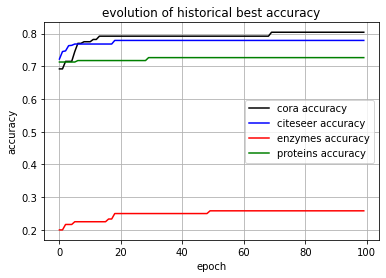

In [20]:
plt.plot(df_cora['epoch'], all_time_best_accuracy_cora, label = "cora accuracy", color="black")
plt.plot(df_citeseer['epoch'], all_time_best_accuracy_citeseer, label = "citeseer accuracy", color="blue")
plt.plot(df_proteins['epoch'], all_time_best_accuracy_enzymes, label = "enzymes accuracy", color="red")
plt.plot(df_enzymes['epoch'], all_time_best_accuracy_proteins, label = "proteins accuracy", color="green")
# plt.plot(df_cora['epoch'], all_time_best_loss, label = "loss", color="red")
plt.title('evolution of historical best accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

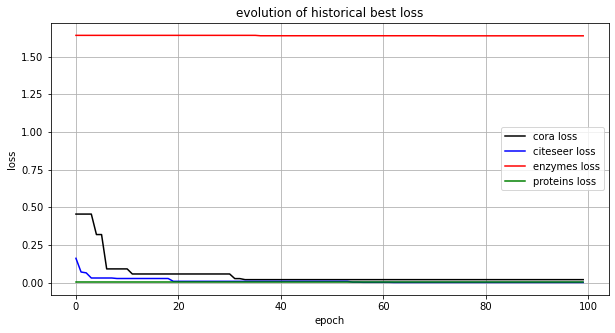

In [21]:
plt.plot(df_cora['epoch'], all_time_best_loss_cora, label = "cora loss", color="black")
plt.plot(df_cora['epoch'], all_time_best_loss_citeseer, label = "citeseer loss", color="blue")
plt.plot(df_proteins['epoch'], all_time_best_loss_enzymes, label = "enzymes loss", color="red")
plt.plot(df_enzymes['epoch'], all_time_best_loss_proteins, label = "proteins loss", color="green")
# plt.plot(df_cora['epoch'], all_time_best_loss, label = "loss", color="red")
plt.title('evolution of historical best loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

In [22]:
all_time_best_average_accuracy_cora = list()
all_time_best_average_loss_cora = list()
all_time_best_average_accuracy_citeseer = list()
all_time_best_average_loss_citeseer = list()
all_time_best_average_accuracy_proteins = list()
all_time_best_average_loss_proteins = list()
all_time_best_average_accuracy_enzymes = list()
all_time_best_average_loss_enzymes = list()
tmp_best_average_accuracy = 0.0
tmp_best_average_loss = 1000.0

for index, row in df_cora.iterrows():
    if float(row['average_accuracy']) > tmp_best_average_accuracy:
        tmp_best_average_accuracy = float(row['average_accuracy'])
    if float(row['average_loss']) < tmp_best_average_loss:
        tmp_best_average_loss = float(row['average_loss'])
    all_time_best_average_accuracy_cora.append(tmp_best_average_accuracy)
    all_time_best_average_loss_cora.append(tmp_best_average_loss)

tmp_best_average_accuracy = 0.0
tmp_best_average_loss = 1000.0

for index, row in df_citeseer.iterrows():
    if float(row['average_accuracy']) > tmp_best_average_accuracy:
        tmp_best_average_accuracy = float(row['average_accuracy'])
    if float(row['average_loss']) < tmp_best_average_loss:
        tmp_best_average_loss = float(row['average_loss'])
    all_time_best_average_accuracy_citeseer.append(tmp_best_average_accuracy)
    all_time_best_average_loss_citeseer.append(tmp_best_average_loss)

tmp_best_average_accuracy = 0.0

for index, row in df_proteins.iterrows():
    if float(row['average_accuracy']) > tmp_best_average_accuracy:
        tmp_best_average_accuracy = float(row['average_accuracy'])
    if float(row['average_loss']) < tmp_best_average_loss:
        tmp_best_average_loss = float(row['average_loss'])
    all_time_best_average_accuracy_proteins.append(tmp_best_average_accuracy)
    all_time_best_average_loss_proteins.append(tmp_best_average_loss)

tmp_best_average_accuracy = 0.0
tmp_best_average_loss = 1000.0

for index, row in df_enzymes.iterrows():
    if float(row['average_accuracy']) > tmp_best_average_accuracy:
        tmp_best_average_accuracy = float(row['average_accuracy'])
    if float(row['average_loss']) < tmp_best_average_loss:
        tmp_best_average_loss = float(row['average_loss'])
    all_time_best_average_accuracy_enzymes.append(tmp_best_average_accuracy)
    all_time_best_average_loss_enzymes.append(tmp_best_average_loss)

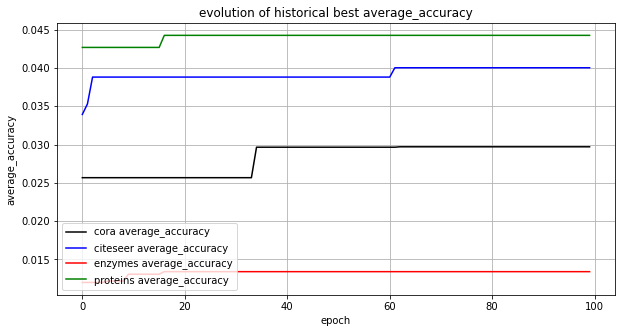

In [23]:
plt.plot(df_cora['epoch'], all_time_best_average_accuracy_cora, label = "cora average_accuracy", color="black")
plt.plot(df_citeseer['epoch'], all_time_best_average_accuracy_citeseer, label = "citeseer average_accuracy", color="blue")
plt.plot(df_proteins['epoch'], all_time_best_average_accuracy_enzymes, label = "enzymes average_accuracy", color="red")
plt.plot(df_enzymes['epoch'], all_time_best_average_accuracy_proteins, label = "proteins average_accuracy", color="green")
plt.title('evolution of historical best average_accuracy')
plt.xlabel('epoch')
plt.ylabel('average_accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

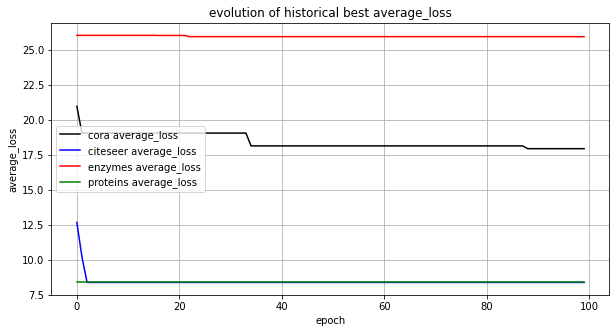

In [24]:
plt.plot(df_cora['epoch'], all_time_best_average_loss_cora, label = "cora average_loss", color="black")
plt.plot(df_citeseer['epoch'], all_time_best_average_loss_citeseer, label = "citeseer average_loss", color="blue")
plt.plot(df_proteins['epoch'], all_time_best_average_loss_enzymes, label = "enzymes average_loss", color="red")
plt.plot(df_enzymes['epoch'], all_time_best_average_loss_proteins, label = "proteins average_loss", color="green")
plt.title('evolution of historical best average_loss')
plt.xlabel('epoch')
plt.ylabel('average_loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

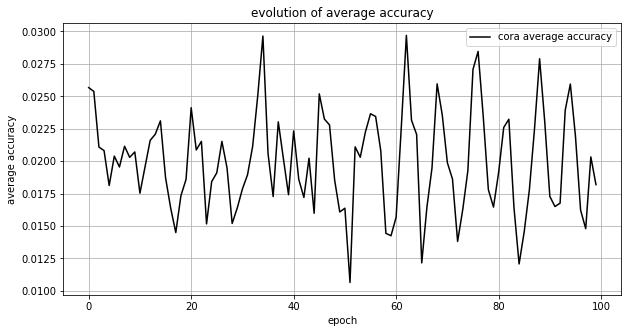

In [25]:
plt.plot(df_cora['epoch'], df_cora["average_accuracy"], label = "cora average accuracy", color="black")
plt.title('evolution of average accuracy')
plt.xlabel('epoch')
plt.ylabel('average accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

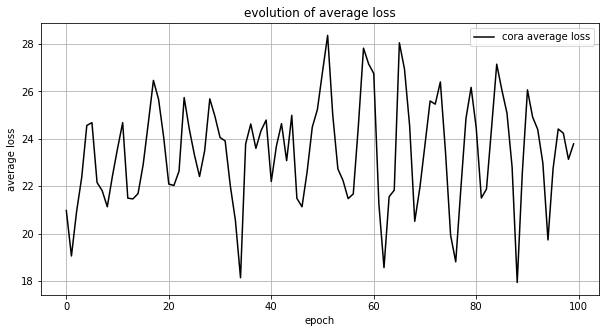

In [26]:
plt.plot(df_cora['epoch'], df_cora["average_loss"], label = "cora average loss", color="black")
plt.title('evolution of average loss')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

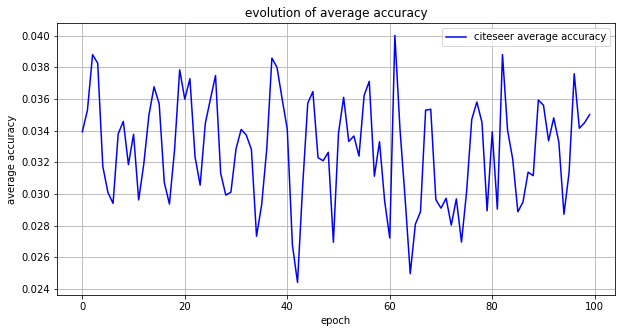

In [27]:
plt.plot(df_citeseer['epoch'], df_citeseer["average_accuracy"], label = "citeseer average accuracy", color="blue")
plt.title('evolution of average accuracy')
plt.xlabel('epoch')
plt.ylabel('average accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

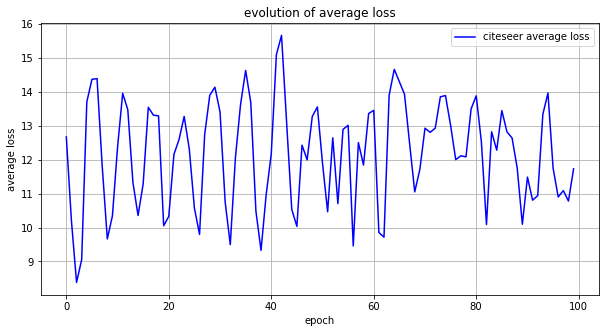

In [28]:
plt.plot(df_citeseer['epoch'], df_citeseer["average_loss"], label = "citeseer average loss", color="blue")
plt.title('evolution of average loss')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

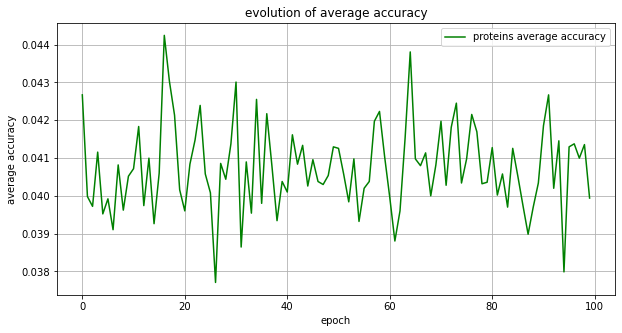

In [29]:
plt.plot(df_proteins['epoch'], df_proteins["average_accuracy"], label = "proteins average accuracy", color="green")
plt.title('evolution of average accuracy')
plt.xlabel('epoch')
plt.ylabel('average accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

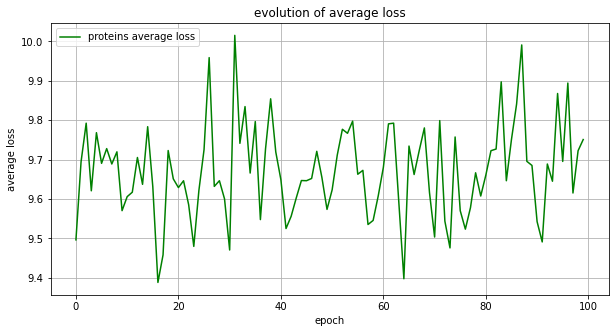

In [30]:
plt.plot(df_proteins['epoch'], df_proteins["average_loss"], label = "proteins average loss", color="green")
plt.title('evolution of average loss')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

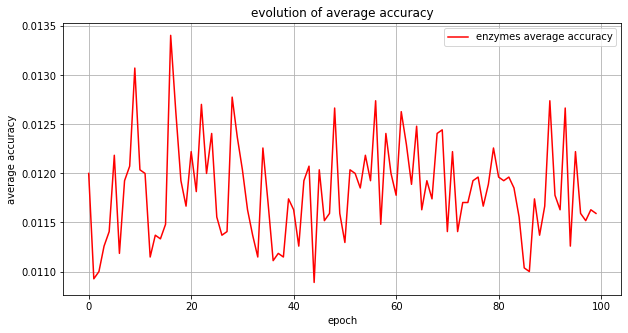

In [31]:
plt.plot(df_enzymes['epoch'], df_enzymes["average_accuracy"], label = "enzymes average accuracy", color="red")
plt.title('evolution of average accuracy')
plt.xlabel('epoch')
plt.ylabel('average accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

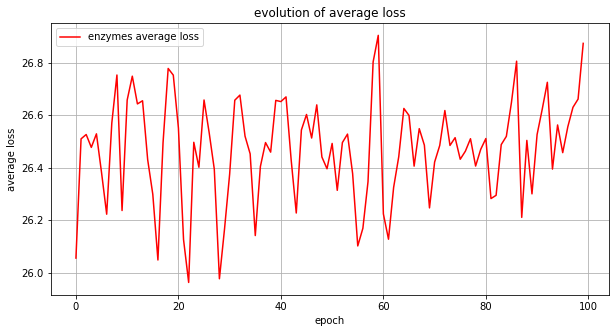

In [32]:
plt.plot(df_enzymes['epoch'], df_enzymes["average_loss"], label = "enzymes average loss", color="red")
plt.title('evolution of average loss')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()